In [17]:
import os
import cv2
import sys
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cvx
from os import listdir
import re
import glob
import numpy as np
from skimage.measure import block_reduce
#from PIL import Image
import random
import pandas as pd

In [18]:
# Parameters of the images
DIM_1 = 192
DIM_2 = 168

In [19]:
# Dense Noise
#Epsilon => we will set epsilon just before calling SOCP
CLASSES = 12
SAMPLE_EACH_CLASS = 68
#DOWNSAMPLE_COEFFICIENT = 2

total_imgs = CLASSES*SAMPLE_EACH_CLASS

In [20]:
###if problem change float to float64
X = np.empty((DIM_1*DIM_2, total_imgs), dtype='float')
delta = np.zeros(shape=(CLASSES, total_imgs)) ## for SRC only
label = np.zeros(total_imgs)

In [21]:
currPath = '/home/swapnil/Desktop/BTP sem VII/CroppedYale/'
#os.chdir(currPath)

In [22]:
X.shape

(32256, 816)

In [23]:
delta.shape

(12, 816)

## Read Images

In [24]:
def read_images(path):
    os.chdir(path)
    directories = sorted(glob.glob('yale*'))
    count=0
    for i in range(CLASSES):
        os.chdir(path+directories[i])
        images = glob.glob('*pgm')
        for image in images:
            img = cv2.imread(image, 0)
            if(img.shape[0]*img.shape[1] == X.shape[0]):
                ### if want to normalize while reading execute below statement
                #img = (img-np.mean(img))/np.std(img)
                X[:,count] = img.flatten()
                label[count]=i+1 ## label is i+1
                count += 1
                delta[i,count]=1
            
    return X, label

In [25]:
X, y = read_images(currPath)
X[:,5]

array([  5.,   5.,   5., ..., 107., 113., 116.])

In [26]:
#plt.imshow(X[:,5].reshape((DIM_1,DIM_2)), cmap='gray')

## Train Test Split

In [27]:
def train_test_data(L, label, delta, frac):
    if 0 in label:
        label = label[:np.where(label==0)[0][0]]
    classes = np.unique(label)
    df = pd.concat([pd.Series(range(len(label)), name='img_no'),pd.Series(label, name='label')],axis=1)
    train_df = df[df.label==1].sample(frac=frac, random_state=42)
    test_df = df[df.label==1].drop(df[df.label==1].sample(frac=frac, random_state=42).index)
    for i in range(len(classes)-1):
        train_df = pd.concat([train_df,df[df.label==i+2].sample(frac=frac, random_state=42)])
        test_df = pd.concat([test_df,df[df.label==i+2].drop(df[df.label==i+2].sample(frac=frac, random_state=42).index)])
    X_train = L[:,train_df.img_no]
    delta = delta[:,train_df.img_no] ###changing delta for only training
    X_test = L[:,test_df.img_no]
    y_train = train_df.label.values
    y_test = test_df.label.values
    return X_train,y_train,X_test,y_test,delta
    

In [28]:
fraction=0.80 ##3to prove accuracy amke it 0.75 or 0.8
X_train,y_train,X_test,y_test,delta = train_test_data(X, y, delta, fraction)

In [29]:
X_train.shape

(32256, 615)

In [30]:
delta.shape

(12, 615)

In [31]:
mean_img = np.mean(X_train, axis=1)
mean_img

array([61.51544715, 62.7902439 , 64.25691057, ..., 46.8       ,
       44.69918699, 43.43902439])

In [32]:
#sd = np.tile(mean_img, (tmp.shape[1],1))

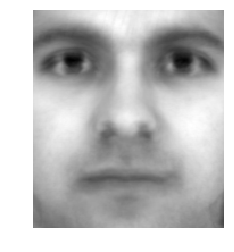

In [33]:
##### mean image
plt.imshow(np.mean(X_train, axis=1).reshape((DIM_1,DIM_2)), cmap='gray')
plt.axis('off')
plt.savefig('mean_img', bbox_inches='tight')

In [34]:
X_train.shape

(32256, 615)

## Eigenspace

In [35]:
def eigenfaces(L,pca_components = 90):
    
    ###mean 
    mean_img = np.mean(L, axis=1) #### calculating mean image
    mean_matrix = np.tile(mean_img, (L.shape[1],1)) #### copying mean image to matrix of same size of X
    L = L - mean_matrix.T  ### subtracting mean from X
    l = L.shape[1] ### l = no. of images
    C = np.matrix(L.transpose()) * np.matrix(L) ### here c= X.T * X
    C /= l-1
    evalues, evectors = np.linalg.eig(C)  ### eigenvectors are column vectors
    ### [::-1] just reverses whatever array you have
    idx = evalues.argsort()[::-1]   ### reversing index max->min
    evalues = evalues[idx]
    evalues = evalues[:pca_components]
    evectors = evectors[:,idx]
    evectors = evectors[:,:pca_components]
    ##you still need to normalize new eigenvectors CHECK1
    evectors = L * evectors ###opencv trick for computation
    evectors = evectors.real ### evectors are complex with 0j
    ## just by normalizing accuracy goes from 36 to 86
    norms = np.linalg.norm(evectors, axis=0)
    evectors = evectors / norms
    #plt.imshow(tmp[:,pca_components/2].reshape((DIM_1, DIM_2)), cmap='gray') ##3 to plot eigenface
    ## now project given images into this subspace
    #features = evectors.T * X
    ## for single image do evectors.T * img(as column)
    return evectors

In [36]:
%%time
### here we have a column of size max_components which is feature to that image
k=200 ## specify how many eigenvctors 
evectors = eigenfaces(X_train,k)

CPU times: user 10 s, sys: 4.74 s, total: 14.8 s
Wall time: 21.7 s


In [37]:
evectors.shape

(32256, 200)

In [38]:
X_train.shape

(32256, 615)

In [39]:
os.chdir('/home/swapnil/Desktop/BTP sem VII')

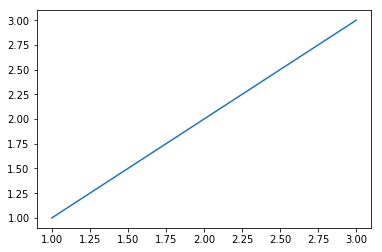

In [35]:
plt.plot([1,2,3], [1,2,3])
plt.show()
plt.savefig('tmp.png',bbox_inches='tight')
fig1 = plt.gcf()
fig1.savefig('tessstttyyy.png', dpi=100)

((32256, 200), (200, 1))


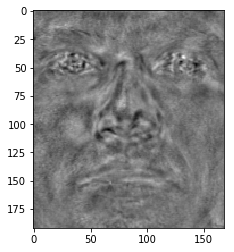

In [168]:
###### reconstruction for image in occluded
test_img = err
test_img = test_img.reshape(-1,1) 
print(evectors.shape, test_img.shape)
reconstructed_img = (evectors*test_img).ravel()
#plt.imshow(X_test[:,img_no].reshape((DIM_1,DIM_2)), cmap='gray')
#plt.axis('off')
plt.imshow(reconstructed_img.reshape((DIM_1,DIM_2)), cmap='gray')

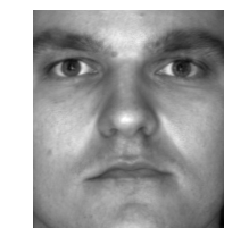

In [114]:
#%matplotlib inline
###reconstruction for image in eigenspace
img_no = 200
test_img = X_test[:,img_no] 
test_img = evectors.T * test_img.reshape(-1,1) 
reconstructed_img = mean_img + (evectors*test_img).ravel()
plt.imshow(X_test[:,img_no].reshape((DIM_1,DIM_2)), cmap='gray')
plt.axis('off')
plt.imshow(reconstructed_img.reshape((DIM_1,DIM_2)), cmap='gray')
#plt.savefig('eigen.png',bbox_inches='tight', pad_inches=0)


## RandomFaces

In [68]:
new_dim = 500
np.random.seed(42)
R = np.random.standard_normal(size=(new_dim,DIM_1*DIM_2))

In [69]:
R.shape

(500, 32256)

In [70]:
R_norm = np.linalg.norm(R, axis=1).shape

In [71]:
R = R/R_norm 

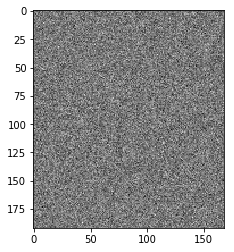

In [72]:
plt.imshow(R[200].reshape((DIM_1, DIM_2)), cmap='gray')
#plt.imshow(X_test[:,img_no].reshape((DIM_1,DIM_2)), cmap='gray')


In [73]:
features = np.matmul(R,X_train)
test_features = np.matmul(R,X_test)

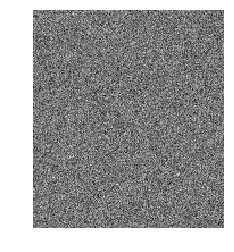

In [81]:
random_img = np.matmul(test_features[:,img_no],R)
plt.axis('off')
plt.imshow(random_img.reshape((DIM_1,DIM_2)), cmap='gray')
plt.savefig('random.png', bbox_inches='tight')

In [229]:
svc.fit(X_train.T, y_train)

In [63]:
predictions = svc.predict(X_test.T)

In [64]:
(y_test==predictions).sum()*100/y_test.shape[0]

91

## Downsampling

In [62]:
DOWNSAMPLE_COEFFICIENT = 12
features = []
for img in X_train.T:
    img = img.reshape((DIM_1, DIM_2))
    img = block_reduce(np.array(img), block_size=(DOWNSAMPLE_COEFFICIENT, DOWNSAMPLE_COEFFICIENT), func=np.mean)
    features.append(img.flatten())
features = np.array(features).T

In [63]:
test_features = []
for img in X_test.T:
    img = img.reshape((DIM_1, DIM_2))
    img = block_reduce(np.array(img), block_size=(DOWNSAMPLE_COEFFICIENT, DOWNSAMPLE_COEFFICIENT), func=np.mean)
    test_features.append(img.flatten())
test_features = np.array(test_features).T

In [64]:
print(features.shape, test_features.shape) ### every image is still column

((224, 390), (224, 379))


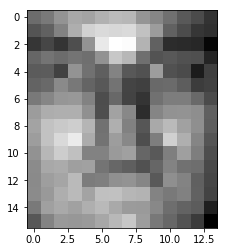

In [66]:
plt.imshow(test_features[:,200].reshape(img.shape), cmap='gray')
plt.savefig('downsample.png', bbox_inches='tight')

In [91]:
svc.fit(X_train.T, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [92]:
predictions = svc.predict(X_test.T)

In [93]:
(y_test==predictions).sum()*100/y_test.shape[0]

91

## Nearest Neighbour

In [40]:
## pass features(K components of test_img)
def nearest_neighbour(L, test_img):
    ###columns of X are images
    copy_matrix = np.tile(test_img, (L.shape[1])) ###copying image into matrix
    residual = L - copy_matrix ### calculate residual 
    ### take absolute difference 
    min_index = np.argmin(np.abs(residual).sum(axis=0)) ### image number with minimum residual
    return min_index ## returning image number
    
    
    

In [188]:
#features.shape

In [189]:
acc=0.0 ### calculating accuracy
features = evectors.T * X_train ### calculate training X in eigenspace
for i in range (X_test.shape[1]):
    test_img = X_test[:,i] 
    test_img = evectors.T * test_img.reshape(-1,1) ###project test image into eigenspace
    #print(i,nearest_neighbour(features, test_img))
    if (y_test[i]==y_train[nearest_neighbour(features, test_img)]) :
        acc +=1
    

In [26]:
X_test.shape[1]

350

In [190]:
acc*100/X_test.shape[1]

90.23746701846966

In [28]:
### use eigen with src from below cells 
###plot k vs accuracy

In [29]:
k_values = [20,50,70,80,100,120,130,150,180,200,250]
accuracies = []
for k in k_values:
    evectors = eigenfaces(X_train,k)
    acc=0.0 ### calculating accuracy
    features = evectors.T * X_train ### calculate training X in eigenspace
    for i in range (X_test.shape[1]):
        test_img = X_test[:,i] 
        test_img = evectors.T * test_img.reshape(-1,1) ###project test image into eigenspace
        if (y_test[i]==y_train[nearest_neighbour(features, test_img)]) :
            acc +=1
    accuracies.append(acc*100/X_test.shape[1])
    print(acc*100/X_test.shape[1])


66.2857142857
81.4285714286
84.8571428571
84.5714285714
86.0
86.2857142857
86.5714285714
86.8571428571
88.0
88.5714285714
89.1428571429


Text(0,0.5,u'accuracy')

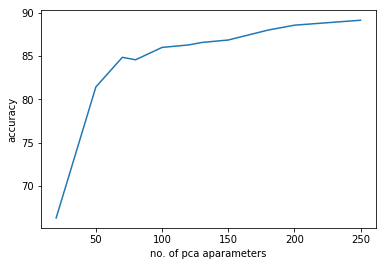

In [30]:
plt.plot(k_values, accuracies)
plt.xlabel('no. of pca aparameters')
plt.ylabel('accuracy')

## Nearest Subspace

In [98]:
## pass features(K components of test_img)
subspace_size = 3
##IMP OBS keep subspace size smaller , more accuracy
def nearest_subspace(L, test_img):
    #subspace_size = 12
    ###columns of X are images
    copy_matrix = np.tile(test_img, (L.shape[1])) ###copying image into matrix
    residual = L - copy_matrix ### calculate residual 
    ### take absolute difference 
    diff = np.abs(residual).sum(axis=0)
    #print(type(diff))
    ##matrix to numpy array problem
    diff = np.array(diff.ravel()).ravel()
    #print(type(diff))
    
    return diff ## returning image number

In [135]:
##IMP you can try weighted nearest subspace

In [61]:
k_values = [20,50]
accuracies = []
for k in k_values:
    evectors = eigenfaces(X_train,k)
    acc=0.0 ### calculating accuracy
    features = evectors.T * X_train ### calculate training X in eigenspace
    for i in range (X_test.shape[1]):
        test_img = X_test[:,i] 
        test_img = evectors.T * test_img.reshape(-1,1) ###project test image into eigenspace
        diff = nearest_subspace(features, test_img)
        
        if (y_test[i]==np.argmax(np.bincount(y_train[np.argpartition(diff,subspace_size)[:subspace_size]].astype(int)))) :
            acc +=1
    accuracies.append(acc*100/X_test.shape[1])
    print(acc*100/X_test.shape[1])


74.6753246753
86.3636363636


In [67]:
#diff

Text(0,0.5,u'accuracy')

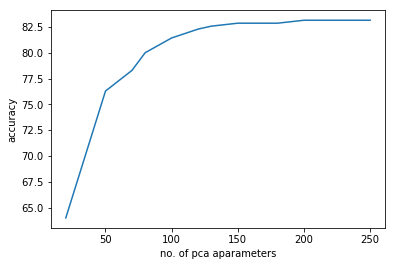

In [137]:
plt.plot(k_values, accuracies)
plt.xlabel('no. of pca aparameters')
plt.ylabel('accuracy')

## SRC

In [114]:
def src(A,y, Epsilon, robust=False):
    
    if (robust == False):
        size = A.shape[1]
        x = cvx.Variable(size)
        obj = cvx.norm(x,1)
        obj = cvx.Minimize(obj)

        constraints = [cvx.norm(A*x - y,2) <= Epsilon]


    else:
        x_size = A.shape[1]
        err_size = A.shape[0]

        # Define the variables, constraints and object of the optimization problem
        x = cvx.Variable(x_size)
        err = cvx.Variable(err_size)
        obj = cvx.Minimize(cvx.norm(x,1) + cvx.norm(err,1))
        constraints = [ A*x - err == y]
    
    prob = cvx.Problem(obj, constraints)
    prob.solve()
    #print("Status:",prob.status)    
    X_hat = x.value
    X_hat.resize((X_hat.shape[0],1))
    residual = X_hat*delta.T
    testCopy = np.tile(y,(CLASSES,1))
    testCopy = np.transpose(testCopy)
    #print(testCopy.shape, np.dot(A, residual).shape)
    M = (testCopy - np.dot(A, residual)) ##IMP **2 removed
    mistake=np.array(M.ravel()).ravel()**2
    mistake=mistake.reshape(M.shape)
    #print(type(mistake))
    #print(mistake.shape)
    return  np.argmin(np.sum(mistake, axis=0))+1 ###returning class number

In [115]:
X_train[:,(y_train==7)][:,0].shape

(32256,)

In [117]:
k_values = [20,50,70,80,100,120,130,150,180,200,250]
k_values = [100]
## OBS as k increases src accuracy increses
accuracies = []
for k in k_values:
    evectors = eigenfaces(X_train,k)
    acc=0.0 ### calculating accuracy
    features = evectors.T * X_train ### calculate training X in eigenspace
    for i in range (X_test.shape[1]):
        test_img = X_test[:,i] 
        test_img = evectors.T * test_img.reshape(-1,1) ###project test image into eigenspace
        test_img = np.array([number.item(0) for number in test_img])
        Epsilon=10
        if (y_test[i]==src(features,test_img, Epsilon)) :
            acc +=1
    accuracies.append(acc*100/X_test.shape[1])
    print(acc*100/X_test.shape[1])

99.3506493506


## SVM

In [46]:
from sklearn import svm


In [59]:
C = 1.0 # SVM regularization parameter
##pass X_train.T beacuse svm takes rows as sample
svc = svm.SVC(kernel='linear', C=C, decision_function_shape='ovr')


In [43]:
svc.fit(X_train.T, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [46]:
predictions = svc.predict(X_test.T)

In [51]:
(y_test==predictions).sum()*100/y_test.shape[0]

89

In [55]:
y_train.shape

(360,)

In [64]:
    features = evectors.T * X_train
    test_features = evectors.T * X_test
    svc = svm.SVC(kernel='linear', C=1, decision_function_shape='ovr')
    svc.fit(features.T, y_train)
    predictions = svc.predict(test_features.T)
    print((y_test==predictions).sum()*100/y_test.shape[0])

90


In [138]:
k_values = [20,50,70,80,100,120,130,150,180,200,250]
#k_values = [100]
## OBS as k increases src accuracy increses
accuracies = []
for k in k_values:
    evectors = eigenfaces(X_train,k)
    acc=0.0 ### calculating accuracy
    features = evectors.T * X_train ### calculate training X in eigenspace
    #features = evectors.T * X_train
    test_features = evectors.T * X_test
    svc = svm.SVC(kernel='linear', C=1, decision_function_shape='ovr')
    svc.fit(features.T, y_train)
    predictions = svc.predict(test_features.T)
    print((y_test==predictions).sum()*100/y_test.shape[0])
    accuracies.append((y_test==predictions).sum()*100/y_test.shape[0])

81
84
82
82
82
82
84
84
84
84
84


Text(0,0.5,u'accuracy')

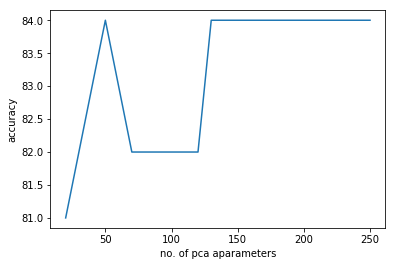

In [139]:
plt.plot(k_values, accuracies)
plt.xlabel('no. of pca aparameters')
plt.ylabel('accuracy')

## Plotting multiple plots algoithmwise

In [119]:
%%time
## eigen space
k_values = [100,300,500]
## OBS as k increases src accuracy increses
accuracies1 = []
for k in k_values:
    evectors = eigenfaces(X_train,k)
    acc=0.0 ### calculating accuracy
    features = evectors.T * X_train ### calculate training X in eigenspace
    for i in range (X_test.shape[1]):
        test_img = X_test[:,i] 
        test_img = evectors.T * test_img.reshape(-1,1) ###project test image into eigenspace
        test_img = np.array([number.item(0) for number in test_img])
        Epsilon=10
        if (y_test[i]==src(features,test_img, Epsilon)) :
            acc +=1
    accuracies1.append(acc*100/X_test.shape[1])
    print(acc*100/X_test.shape[1])

99.3506493506
98.0519480519
98.7012987013
CPU times: user 16min 36s, sys: 1min 48s, total: 18min 25s
Wall time: 15min 46s


In [ ]:
accuracies1 = [99.3506493506, 98.0519480519,98.7012987013]
src_eigen_acc = [99.3506493506, 98.0519480519,98.7012987013]


In [ ]:
###downsampling
coeffs = [8,10,12,16,20]
accuracies2 = []
dimension_size = []
for down_coef in coeffs:
    features = []
    for img in X_train.T:
        img = img.reshape((DIM_1, DIM_2))
        img = block_reduce(np.array(img), block_size=(down_coef, down_coef), func=np.mean)
        features.append(img.flatten())
    dimension_size.append(img.shape[0]*img.shape[1])
    features = np.array(features).T
    test_features = []
    for img in X_test.T:
        img = img.reshape((DIM_1, DIM_2))
        img = block_reduce(np.array(img), block_size=(down_coef, down_coef), func=np.mean)
        test_features.append(img.flatten())
    test_features = np.array(test_features).T
    acc=0
    for i in range (test_features.shape[1]):
        test_img = test_features[:,i] 
        test_img = test_img.reshape(-1,1)
        test_img = np.array([number.item(0) for number in test_img])
        #print(features.shape, test_img.shape)
        Epsilon=500 
        if (y_test[i]==src(features,test_img, Epsilon)) :
            acc +=1
    accuracies2.append(acc*100/X_test.shape[1])
    print(acc*100/X_test.shape[1])    

#### reversing the dimension sizes
dimension_size = dimension_size[::-1]
accuracies2 = accuracies2[::-1]

In [ ]:
### random 
k_values = [100,300,500]
accuracies3 = []
for new_dim in k_values:
    np.random.seed(42)
    R = np.random.standard_normal(size=(new_dim,DIM_1*DIM_2))
    R_norm = np.linalg.norm(R, axis=1).shape
    R = R/R_norm 
    features = np.matmul(R,X_train)
    test_features = np.matmul(R,X_test)
    acc=0
    for i in range (test_features.shape[1]):
        test_img = test_features[:,i] 
        test_img = test_img.reshape(-1,1)
        test_img = np.array([number.item(0) for number in test_img])

        #print(features.shape, test_img.shape)
        Epsilon=500        
        if (y_test[i]==src(features,test_img, Epsilon)) :
            acc +=1
    accuracies3.append(acc*100/X_test.shape[1])
    print(acc*100/X_test.shape[1])

In [ ]:
###plotting
plt.plot(k_values, accuracies1, color='orange', label='Eigen+NN')
plt.plot(dimension_size, accuracies2, color='green', label='Downsampling+NN')
plt.plot(k_values, accuracies3, color='blue', label='Random+NN')
plt.ylim(40,100)
plt.legend()
plt.xlabel('Feature Dimension')
plt.ylabel('Recognition Rate Percentage ')
plt.title('SRC')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.savefig('SRC.png', bbox_inches='tight')
plt.show()

### nearest neighbour

In [41]:
### feature extraction  eigen
k_values = [100,200,300,400,500]
accuracies1 = []
for k in k_values:
    evectors = eigenfaces(X_train,k)
    acc=0.0 ### calculating accuracy
    features = evectors.T * X_train ### calculate training X in eigenspace
    for i in range (X_test.shape[1]):
        test_img = X_test[:,i] 
        test_img = evectors.T * test_img.reshape(-1,1) ###project test image into eigenspace
        if (y_test[i]==y_train[nearest_neighbour(features, test_img)]) :
            acc +=1
    accuracies1.append(acc*100/X_test.shape[1])
    print(acc*100/X_test.shape[1])

92.8571428571
94.8051948052
94.1558441558
94.8051948052
94.8051948052


In [42]:
###downsampling
coeffs = [8,10,12,16,20]
accuracies2 = []
dimension_size = []
for down_coef in coeffs:
    features = []
    for img in X_train.T:
        img = img.reshape((DIM_1, DIM_2))
        img = block_reduce(np.array(img), block_size=(down_coef, down_coef), func=np.mean)
        features.append(img.flatten())
    dimension_size.append(img.shape[0]*img.shape[1])
    features = np.array(features).T
    test_features = []
    for img in X_test.T:
        img = img.reshape((DIM_1, DIM_2))
        img = block_reduce(np.array(img), block_size=(down_coef, down_coef), func=np.mean)
        test_features.append(img.flatten())
    test_features = np.array(test_features).T
    acc=0
    for i in range (test_features.shape[1]):
        test_img = test_features[:,i] 
        test_img = test_img.reshape(-1,1)
        #print(features.shape, test_img.shape)
        if (y_test[i]==y_train[nearest_neighbour(features, test_img)]) :
            acc +=1
    accuracies2.append(acc*100/X_test.shape[1])
    print(acc*100/X_test.shape[1])    

#### reversing the dimension sizes
dimension_size = dimension_size[::-1]
accuracies2 = accuracies2[::-1]

68
65
62
58
51


In [43]:
### random 
k_values = [100,200,300,400,500]
accuracies3 = []
for new_dim in k_values:
    np.random.seed(42)
    R = np.random.standard_normal(size=(new_dim,DIM_1*DIM_2))
    R_norm = np.linalg.norm(R, axis=1).shape
    R = R/R_norm 
    features = np.matmul(R,X_train)
    test_features = np.matmul(R,X_test)
    acc=0
    for i in range (test_features.shape[1]):
        test_img = test_features[:,i] 
        test_img = test_img.reshape(-1,1)
        #print(features.shape, test_img.shape)
        if (y_test[i]==y_train[nearest_neighbour(features, test_img)]) :
            acc +=1
    accuracies3.append(acc*100/X_test.shape[1])
    print(acc*100/X_test.shape[1])       

76
79
79
79
80


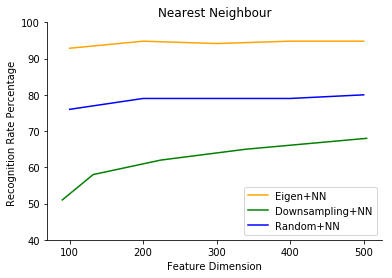

In [45]:
###plotting
plt.plot(k_values, accuracies1, color='orange', label='Eigen+NN')
plt.plot(dimension_size, accuracies2, color='green', label='Downsampling+NN')
plt.plot(k_values, accuracies3, color='blue', label='Random+NN')
plt.ylim(40,100)
plt.legend()
plt.xlabel('Feature Dimension')
plt.ylabel('Recognition Rate Percentage ')
plt.title('Nearest Neighbour')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.savefig('Nearest Neighbour new.png', bbox_inches='tight')
plt.show()

### Nearest Subspace

In [97]:
### feature extraction  eigen
k_values = [100,200,300,400,500]
accuracies1 = []
for k in k_values:
    evectors = eigenfaces(X_train,k)
    acc=0.0 ### calculating accuracy
    features = evectors.T * X_train ### calculate training X in eigenspace
    for i in range (X_test.shape[1]):
        test_img = X_test[:,i] 
        test_img = evectors.T * test_img.reshape(-1,1) ###project test image into eigenspace
        diff = nearest_subspace(features, test_img)
        
        if (y_test[i]==np.argmax(np.bincount(y_train[np.argpartition(diff,subspace_size)[:subspace_size]].astype(int)))) :
            acc +=1
    accuracies1.append(acc*100/X_test.shape[1])
    print(acc*100/X_test.shape[1])

90.9090909091
92.8571428571
92.8571428571
92.8571428571
92.8571428571


In [111]:
###downsampling
coeffs = [8,10,12,16,20]
accuracies2 = []
dimension_size = []
for down_coef in coeffs:
    features = []
    for img in X_train.T:
        img = img.reshape((DIM_1, DIM_2))
        img = block_reduce(np.array(img), block_size=(down_coef, down_coef), func=np.median)
        features.append(img.flatten())
    dimension_size.append(img.shape[0]*img.shape[1])
    features = np.array(features).T
    test_features = []
    for img in X_test.T:
        img = img.reshape((DIM_1, DIM_2))
        img = block_reduce(np.array(img), block_size=(down_coef, down_coef), func=np.median)
        test_features.append(img.flatten())
    test_features = np.array(test_features).T
    acc=0
    for i in range (test_features.shape[1]):
        test_img = test_features[:,i] 
        test_img = test_img.reshape(-1,1)
        #print(features.shape,test_img.shape)
        diff = nearest_subspace(features, test_img)
        
        if (y_test[i]==np.argmax(np.bincount(y_train[np.argpartition(diff,subspace_size)[:subspace_size]].astype(int)))) :
            acc +=1
    accuracies2.append(acc*100/X_test.shape[1])
    print(acc*100/X_test.shape[1])
#### reversing the dimension sizes
dimension_size = dimension_size[::-1]
accuracies2 = accuracies2[::-1]

68
64
65
61
56


In [109]:
### random 
k_values = [100,200,300,400,500]
accuracies3 = []
for new_dim in k_values:
    np.random.seed(42)
    R = np.random.standard_normal(size=(new_dim,DIM_1*DIM_2))
    R_norm = np.linalg.norm(R, axis=1).shape
    R = R/R_norm 
    features = np.matmul(R,X_train)
    test_features = np.matmul(R,X_test)
    acc=0
    for i in range (test_features.shape[1]):
        test_img = test_features[:,i] 
        test_img = test_img.reshape(-1,1)
        #print(features.shape,test_img.shape)
        diff = nearest_subspace(features, test_img)
        
        if (y_test[i]==np.argmax(np.bincount(y_train[np.argpartition(diff,subspace_size)[:subspace_size]].astype(int)))) :
            acc +=1
    accuracies3.append(acc*100/X_test.shape[1])
    print(acc*100/X_test.shape[1])

76
75
77
77
77


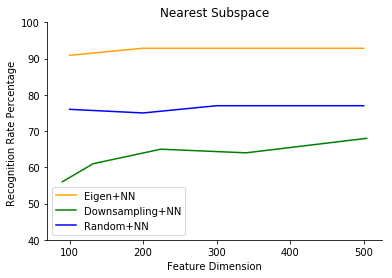

In [113]:
###plotting
plt.plot(k_values, accuracies1, color='orange', label='Eigen+NN')
plt.plot(dimension_size, accuracies2, color='green', label='Downsampling+NN')
plt.plot(k_values, accuracies3, color='blue', label='Random+NN')
plt.ylim(40,100)
plt.legend()
plt.xlabel('Feature Dimension')
plt.ylabel('Recognition Rate Percentage ')
plt.title('Nearest Subspace')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.savefig('Nearest Subspace.png', bbox_inches='tight')
plt.show()

### SVM

In [47]:
### feature extraction  eigen
k_values = [100,200,300,400,500]
accuracies1 = []
## OBS as k increases src accuracy increses
for k in k_values:
    evectors = eigenfaces(X_train,k)
    acc=0.0 ### calculating accuracy
    features = evectors.T * X_train ### calculate training X in eigenspace
    #features = evectors.T * X_train
    test_features = evectors.T * X_test
    svc = svm.SVC(kernel='linear', C=1, decision_function_shape='ovr')
    svc.fit(features.T, y_train)
    predictions = svc.predict(test_features.T)
    print((y_test==predictions).sum()*100/y_test.shape[0])
    accuracies1.append((y_test==predictions).sum()*100/y_test.shape[0])

91
89
89
90
89


In [48]:
###downsampling
coeffs = [8,10,12,16,20]
accuracies2 = []
dimension_size = []
for down_coef in coeffs:
    features = []
    for img in X_train.T:
        img = img.reshape((DIM_1, DIM_2))
        img = block_reduce(np.array(img), block_size=(down_coef, down_coef), func=np.mean)
        features.append(img.flatten())
    dimension_size.append(img.shape[0]*img.shape[1])
    features = np.array(features).T
    test_features = []
    for img in X_test.T:
        img = img.reshape((DIM_1, DIM_2))
        img = block_reduce(np.array(img), block_size=(down_coef, down_coef), func=np.mean)
        test_features.append(img.flatten())
    test_features = np.array(test_features).T
    svc = svm.SVC(kernel='linear', C=1, decision_function_shape='ovr')
    svc.fit(features.T, y_train)
    predictions = svc.predict(test_features.T)
    print((y_test==predictions).sum()*100/y_test.shape[0])
    accuracies2.append((y_test==predictions).sum()*100/y_test.shape[0])
    
#### reversing the dimension sizes
dimension_size = dimension_size[::-1]
accuracies2 = accuracies2[::-1]

90
88
92
88
88


In [49]:
### random 
k_values = [100,200,300,400,500]
accuracies3 = []
for new_dim in k_values:
    np.random.seed(42)
    R = np.random.standard_normal(size=(new_dim,DIM_1*DIM_2))
    R_norm = np.linalg.norm(R, axis=1).shape
    R = R/R_norm 
    features = np.matmul(R,X_train)
    test_features = np.matmul(R,X_test)
    svc = svm.SVC(kernel='linear', C=1, decision_function_shape='ovr')
    svc.fit(features.T, y_train)
    predictions = svc.predict(test_features.T)
    print((y_test==predictions).sum()*100/y_test.shape[0])
    accuracies3.append((y_test==predictions).sum()*100/y_test.shape[0])
 

85
90
92
92
90


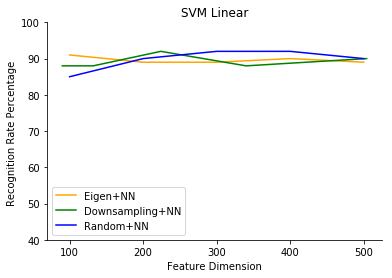

In [51]:
###plotting
plt.plot(k_values, accuracies1, color='orange', label='Eigen+NN')
plt.plot(dimension_size, accuracies2, color='green', label='Downsampling+NN')
plt.plot(k_values, accuracies3, color='blue', label='Random+NN')
plt.ylim(40,100)
plt.legend()
plt.xlabel('Feature Dimension')
plt.ylabel('Recognition Rate Percentage ')
plt.title('SVM Linear')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.savefig('SVM Linear.png', bbox_inches='tight')
plt.show()

## Occlusion

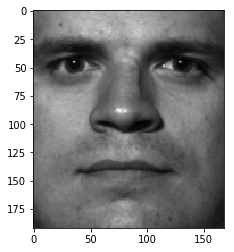

In [131]:
plt.imshow(X_test[:,110].reshape((DIM_1,DIM_2)), cmap='gray')

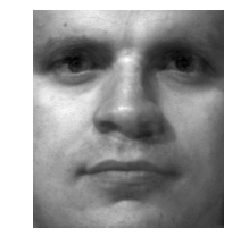

In [145]:
#%matplotlib inline
###reconstruction for image in eigenspace
img_no = 123
data= X_train

test_img = data[:,img_no] 
test_img = evectors.T * test_img.reshape(-1,1) 
reconstructed_img = mean_img + (evectors*test_img).ravel()
plt.axis('off')
plt.imshow(data[:,img_no].reshape((DIM_1,DIM_2)), cmap='gray')
plt.savefig('2st_orig.png',bbox_inches='tight')
plt.imshow(reconstructed_img.reshape((DIM_1,DIM_2)), cmap='gray')
plt.savefig('2st_feature_orig.png',bbox_inches='tight')

In [157]:
#### USUAL for single image
acc=0.0 ### calculating accuracy
features = evectors.T * X_train ### calculate training X in eigenspace
Epsilon=1000
test_img = X_test[:,110] 
test_img = evectors.T * test_img.reshape((test_img.shape[0],1)) ###project test image into eigenspace
test_img = np.array([number.item(0) for number in test_img])
# ,robust=True sent this for robust
res, xhat , output = src(features,test_img, Epsilon)

In [158]:
res.shape

(200, 12)

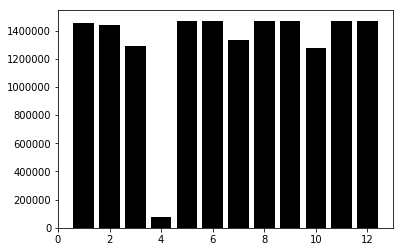

In [161]:
##residual plot
x_axis_values = range(res.shape[1]+1)[1:]
residual_values = res.mean(axis=0)
plt.bar(x_axis_values,residual_values, color='black')
plt.savefig('residual_plot.png',bbox_inches='tight')

In [151]:
res.mean(axis=0)

array([1.84697448e-05, 1.75807290e-05, 1.42297829e-04, 2.06996952e-03,
       3.17933350e-14, 2.15142602e-14, 1.25697312e-04, 2.17071605e-14,
       4.47704520e-14, 1.27133351e-04, 4.70302887e-14, 1.80840958e-14])

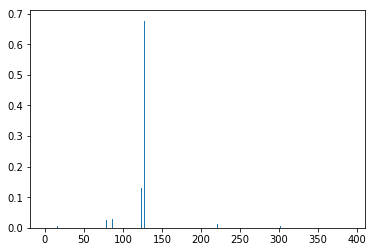

In [140]:
###xhat plot
x_axis_values = range(xhat.shape[0]+1)[1:]
sparse_values = xhat.ravel()
plt.bar(x_axis_values,sparse_values)
plt.savefig('barplot_xvalues.png',bbox_inches='tight')

In [78]:
sdf = [10.00,15312,20,35]
np.argsort(sdf)

array([0, 2, 3, 1])

In [135]:
np.argmax(xhat[:127])

123

127


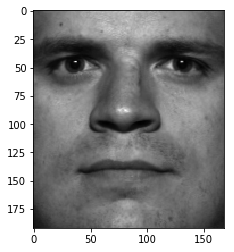

In [143]:
plt.imshow(X_train[:,xhat.argmax()].reshape((DIM_1, DIM_2)), cmap='gray')
print(xhat.argmax())

123


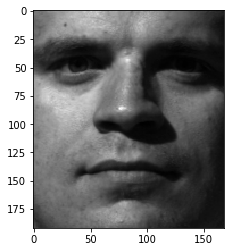

In [136]:
plt.imshow(X_train[:,123].reshape((DIM_1, DIM_2)), cmap='gray')
print(123)

In [139]:
os.chdir('/home/swapnil/Desktop/BTP sem VII')

(216, 190)
(192, 168)
(32256,)


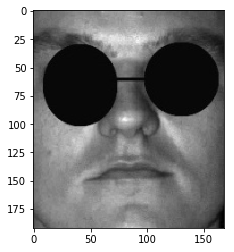

In [175]:
#### OCCLUDED
os.chdir('/home/swapnil/Desktop/BTP sem VII')
test_img = cv2.imread('glass.jpg',0)
print(test_img.shape)
test_img = cv2.resize(test_img, (DIM_2, DIM_1))
plt.imshow(test_img,cmap='gray')

print(test_img.shape)
test_img = test_img.flatten()
print(test_img.shape)

#os.curdir

In [176]:
#### OCCLUDED
acc=0.0 ### calculating accuracy
features =  X_train ### calculate training X in eigenspace
Epsilon=1000
#test_img = X_test[:,100] 
test_img =  test_img.reshape((test_img.shape[0],1)) ###project test image into eigenspace
test_img = np.array([number.item(0) for number in test_img])
# ,robust=True sent this for robust
xhat , err, output = src(features,test_img, Epsilon,robust=True)

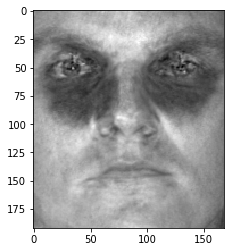

In [184]:
axx = np.matmul(X_train,xhat)
axx.shape
axx_img = axx.reshape(DIM_1,DIM_2)
axx_img.shape
plt.imshow(axx_img, cmap='gray')
plt.savefig('ax.png', bbox_inches='tight')

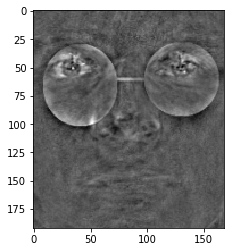

In [185]:
plt.imshow(err.reshape((DIM_1,DIM_2)), cmap='gray')
plt.savefig('err.png', bbox_inches='tight')

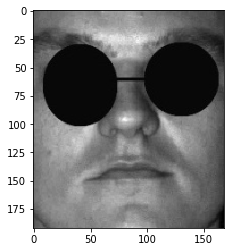

In [186]:
err_image = err.reshape((DIM_1,DIM_2))
plt.imshow(axx_img-err_image, cmap='gray')
plt.savefig('ax-err=y.png', bbox_inches='tight')

In [25]:
#plt.bar(np.array(range(err.shape[0])), err)